In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load Data

In [3]:
import pandas as pd

In [4]:
# train_Xy = pd.read_csv('exploratory_data_analysis/data_elasticsearch/train_Xy.csv')
# val_Xy = pd.read_csv('exploratory_data_analysis/data_elasticsearch//val_Xy.csv')
# test_Xy = pd.read_csv('exploratory_data_analysis/data_elasticsearch//test_Xy.csv')

In [5]:
train_Xy = pd.read_csv('exploratory_data_analysis/data_teammates/train_Xy.csv')
val_Xy = pd.read_csv('exploratory_data_analysis/data_teammates//val_Xy.csv')
test_Xy = pd.read_csv('exploratory_data_analysis/data_teammates//test_Xy.csv')

## Transform Input Data

In [6]:
def consolidate_data(df):
    return df.to_dict(orient='records')

train_data = consolidate_data(train_Xy)
val_data = consolidate_data(val_Xy)
test_data = consolidate_data(test_Xy)

### Tokenize diff-hunks

In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/pu_xiao_berkeley_edu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
from collections import Counter
from nltk import word_tokenize

character_counts = Counter()
word_counts = Counter()

# only count for train and val
for record in train_data:
    character_counts.update(record['augmented_diff_hunk'])
for record in val_data:
    character_counts.update(record['augmented_diff_hunk'])
    
for record in train_data:
    word_counts.update(word_tokenize(record['body']))
for record in val_data:
    word_counts.update(word_tokenize(record['body']))

In [9]:
diff_max_length = 400

special_character = ["<START>", "UNK", "PAD"]
characters = special_character + [w for w, c in character_counts.most_common(100)]
c2i = {c: i for i, c in enumerate(sorted(characters))}
i2c = {v: k for k, v in c2i.items()}

unkI_c, padI_c, startI_c = c2i['UNK'], c2i['PAD'], c2i['<START>']

In [10]:
import json
with open('code_to_review/saved_data/code_to_review_c2i.json', 'w') as f:
    json.dump(c2i, f)
with open('code_to_review/saved_data/code_to_review_i2c.json', 'w') as f:
    json.dump(i2c, f)

In [11]:
body_max_length = 100

words = special_character + [w for w, c in word_counts.most_common(1000)]
w2i = {w: i for i, w in enumerate(sorted(words))}
i2w = {v: k for k, v in w2i.items()}

unkI_w, padI_w, startI_w = w2i['UNK'], w2i['PAD'], w2i['<START>']

In [12]:
import json
with open('code_to_review/saved_data/code_to_review_w2i.json', 'w') as f:
    json.dump(w2i, f)
with open('code_to_review/saved_data/code_to_review_i2w.json', 'w') as f:
    json.dump(i2w, f)

### Tokenize Reviews

In [13]:
# tokenize reviews
import numpy as np
from nltk import tokenize
import torch
from transformers import *

In [14]:
import re

def numerize_diff_hunk(diff_hunk):
    return [c2i.get(c, unkI_c) for c in diff_hunk]

def numerized_to_diff(numerized):
    return "".join([i2c.get(i) for i in numerized])

def numerize_body(body):
    words = word_tokenize(body)
    return [w2i.get(w, unkI_w) for w in words]

def numerized_to_word(numerized):
    return " ".join([i2w.get(i) for i in numerized])

def pad_sequence(numerized, max_length, padI):
    pad = numerized[:max_length]
    padded = pad + [padI] * (max_length - len(pad))
    return padded

def calculate_mask(padded, padI):
    return [c != padI for c in padded]

def preprocess(data):
    for record in data:
        #clean_review = record['body'].replace("\n", " ").replace("`", "")
        clean_review = re.sub(r'`.+`', '', record['body'].replace("\n", " "))
        
        record['body_encoded'] = pad_sequence(numerize_body(clean_review), body_max_length, padI_w)
        record['body_mask'] = calculate_mask(record['body_encoded'], padI_w)
        
        record['diff_hunk_encoded'] = pad_sequence(numerize_diff_hunk(record['augmented_diff_hunk']), 
                                                   diff_max_length, padI_c)
        record['diff_hunk_mask'] = calculate_mask(record['diff_hunk_encoded'], padI_c)

In [15]:
preprocess(train_data)
preprocess(val_data)
preprocess(test_data)

In [16]:
val_Xy['body'][2]

"Split this method into multiple methods.\nIt's currently so long, I can't see exactly what you're trying to do here in each segment of this method.\n\nThere's no need to use the `this` keyword when it's not necessary (like in getters); that only makes it harder to read, use it only when it serves a purpose.\nIf you're using `*Param` as your variable names, don't combine them with `this.*`.\n"

In [17]:
numerized_to_word(val_data[2]['body_encoded'])

"UNK this method into multiple methods . It 's currently so long , I ca n't see exactly what you 're trying to do here in each UNK of this method . There 's no need to use the . PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD"

### Build Batch

In [18]:
def build_batch(dataset, batch_size):
    indices = list(np.random.randint(0, len(dataset), size=min(batch_size, len(dataset))))
    
    batch = [dataset[i] for i in indices]
    
    y_encoded = np.array([element['body_encoded'] for element in batch])
    start_tokens = np.full((batch_size, 1), startI_w)
    y_input = np.concatenate((start_tokens, y_encoded), axis=1)
    y_input = y_input[:, :-1]
    
    y_target = y_encoded
    
    y_target_mask = np.array([a['body_mask'] for a in batch])
    
    X_encoded = np.array([element['diff_hunk_encoded'] for element in batch])
    X_mask = np.array([element['diff_hunk_mask'] for element in batch])

    return X_encoded, X_mask, y_input, y_target, y_target_mask

In [19]:
X_encoded, X_mask, y_input, y_target, y_target_mask = build_batch(train_data, 10)

print(X_encoded.shape)
print(X_mask.shape)
print(y_input.shape)
print(y_target.shape)
print(y_target_mask.shape)

(10, 400)
(10, 400)
(10, 100)
(10, 100)
(10, 100)


In [20]:
numerized_to_word(y_input[7])

'<START> UNK point can not be less than 1 right ? PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD'

### Model

In [21]:
import torch
import torch.nn as nn

In [ ]:
from code_to_review.models.code_to_review_lstm import CodeToReviewModelLSTM

In [22]:
from code_to_review.models.code_to_review_transformer import CodeToReviewModelTransformer

### Visualization

In [23]:
from util.training_process_recorder import TrainingProcess

### Trainning

In [ ]:
code_to_review_model = CodeToReviewModelLSTM(startI_w=startI_w, code_characters_size=len(c2i), 
                                             code_max_length=diff_max_length, 
                                             review_vocab_size=len(w2i), should_tune_encoder=True,
                                             hidden_size=384, num_hidden_layers=4,
                                             num_attention_heads=4, intermediate_size=256,
                                             word_embed_dim=256, hidden_dim=256, lstm_layers=1, output_attentions=False)
code_to_review_model = code_to_review_model.to(code_to_review_model.device)

In [24]:
code_to_review_model = CodeToReviewModelTransformer(startI_w=startI_w, padI_w=padI_w, 
                                                    code_characters_size=len(c2i), review_vocab_size=len(w2i), 
                                                    output_attentions=False, should_tune_encoder=True,
                                                    encoder_hidden_size=384, encoder_num_layers=4, 
                                                    encoder_num_attention_heads=4, encoder_intermediate_size=256,
                                                    decoder_hidden_size=384, decoder_num_layers=4, 
                                                    decoder_num_attention_heads=4, decoder_intermediate_size=256)
code_to_review_model = code_to_review_model.to(code_to_review_model.device)

In [25]:
tp = TrainingProcess()

In [ ]:
if torch.cuda.is_available():
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_lstm_clean.save'))
else:
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_lstm_clean.save', 
                                                    map_location=torch.device('cpu')))

code_to_review_model.eval();
tp.load("code_to_review/saved_data/code_to_review_lstm_tp.save")

In [ ]:
if torch.cuda.is_available():
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_transformer.save'))
else:
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_transformer.save', 
                                                    map_location=torch.device('cpu')))

code_to_review_model.eval();
tp.load("code_to_review/saved_data/code_to_review_transformer_tp.save")

In [26]:
if torch.cuda.is_available():
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_transformer_clean.save'))
else:
    code_to_review_model.load_state_dict(torch.load('code_to_review/saved_data/code_to_review_transformer_clean.save', 
                                                    map_location=torch.device('cpu')))

code_to_review_model.eval();
tp.load("code_to_review/saved_data/code_to_review_transformer_clean_tp.save")

In [ ]:
params = list(code_to_review_model.parameters())
optimizer = torch.optim.Adam(params, lr=0.0002, weight_decay=0.0020)
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.995)

num_epochs = 30
batch_size = 64
log_step = 30

for epoch in range(num_epochs):
    num_train = len(train_data)
    iterations_per_epoch = max(num_train // batch_size, 1)
    
    for i in range(iterations_per_epoch):
        minibatch = build_batch(train_data, batch_size)
        X_encoded, X_mask, y_input, y_target, y_target_mask = minibatch
        code_to_review_model.train()
        code_to_review_model.zero_grad()
        loss = code_to_review_model(X_encoded, X_mask, y_input, y_target, y_target_mask)
        loss.backward()
        optimizer.step()
        
        tp.record_train(loss.item())
        tp.step()
        
        # Print log info
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i, iterations_per_epoch, loss.item()))

    val_minibatch = build_batch(val_data, batch_size)
    val_X_encoded, val_X_mask, val_y_input, val_y_target, val_y_target_mask = val_minibatch
    code_to_review_model.eval()
    code_to_review_model.zero_grad()
    val_loss = code_to_review_model(val_X_encoded, val_X_mask, val_y_input, val_y_target, val_y_target_mask)
    
    tp.record_val(val_loss.item())
    
    print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, val_loss.item()))
    
    tp.record_epoch()
    
    my_lr_scheduler.step()

In [ ]:
for i in range(len(test_data) // 64):
    test_minibatch = build_batch(test_data, 64)
    test_X_encoded, test_X_mask, test_y_input, test_y_target, test_y_target_mask = test_minibatch
    code_to_review_model.eval()
    code_to_review_model.zero_grad()
    test_loss = code_to_review_model(test_X_encoded, test_X_mask, test_y_input, test_y_target, test_y_target_mask)

    tp.record_test(test_loss.item())

    print('[Round {}] Test Loss: {:.4f}'.format(i + 1, test_loss.item()))

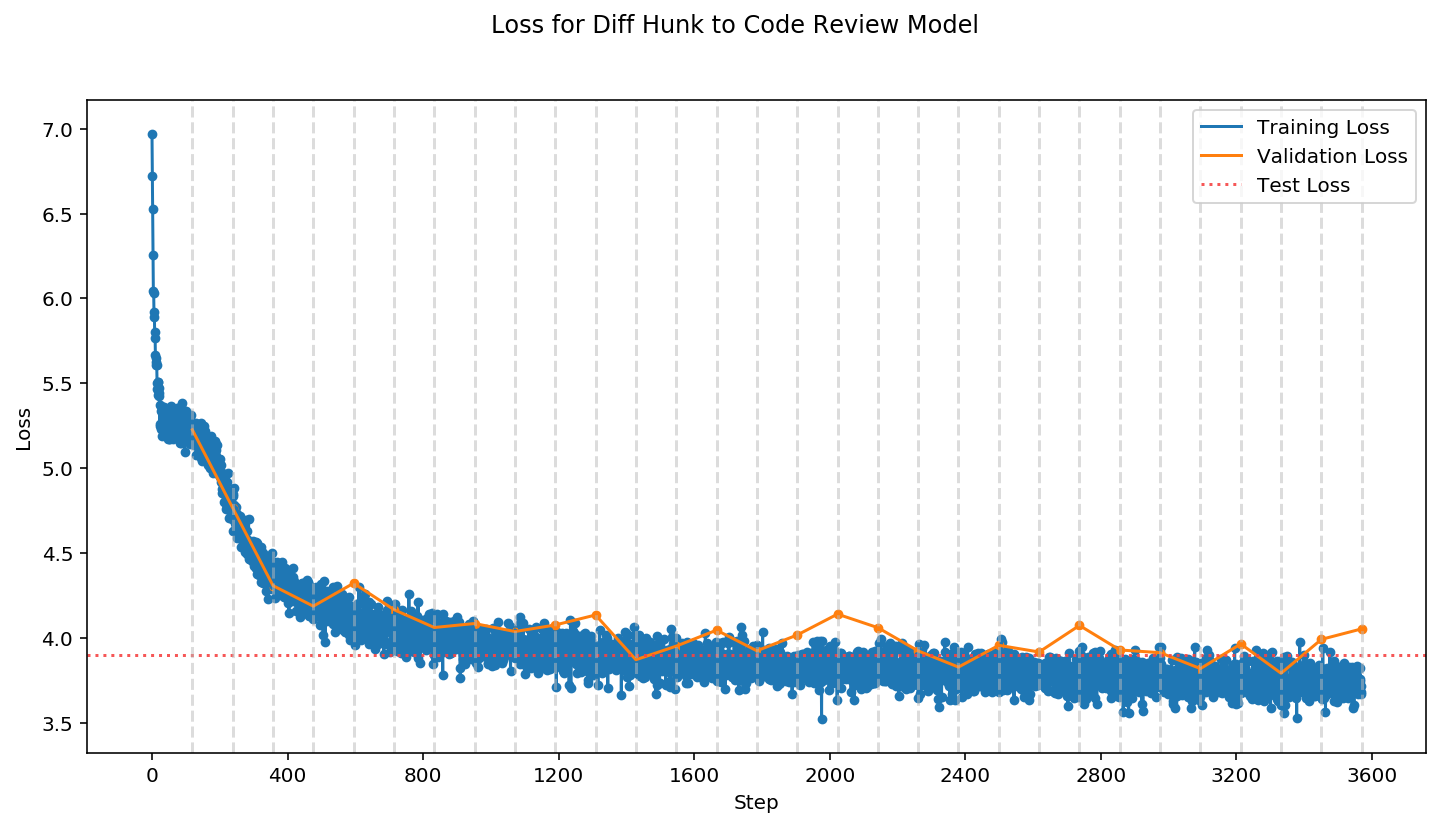

In [27]:
tp.visualize(title="Loss for Diff Hunk to Code Review Model")

In [ ]:
torch.save(code_to_review_model.state_dict(), 'code_to_review/saved_data/code_to_review_lstm_clean.save')
tp.save('code_to_review/saved_data/code_to_review_lstm_clean_tp.save')

In [ ]:
torch.save(code_to_review_model.state_dict(), 'code_to_review/saved_data/code_to_review_transformer.save')
tp.save('code_to_review/saved_data/code_to_review_transformer_tp.save')

In [ ]:
torch.save(code_to_review_model.state_dict(), 'code_to_review/saved_data/code_to_review_transformer_clean.save')
tp.save('code_to_review/saved_data/code_to_review_transformer_clean_tp.save')

### Generation

In [28]:
minibatch = build_batch(train_data, 3)
code_encoded, code_mask, y_input, y_target, y_target_mask = minibatch

generated_texts = code_to_review_model.sample(code_encoded, code_mask, max_length=30, beam_size=4, topK=1)[0]

original_texts = y_target

for numerized, real_numberized in zip(generated_texts, original_texts):
    print("Generated:\n")
    for n in numerized:
        print(numerized_to_word(n))
        print('\n')

    print("Original:\n%s" % numerized_to_word(real_numberized))
    print('\n')

Generated:

<START> This can be UNK to UNK the UNK . UNK the UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK


Original:
UNK UNK , but why is the `` UNK '' UNK ? : P PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD


Generated:

<START> I 'm UNK the UNK of the UNK of UNK UNK UNK UNK , but I think you can UNK the UNK of the UNK of the UNK of the


Original:
remove whitespace changes PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 

In [29]:
minibatch = build_batch(test_data, 3)
code_encoded, code_mask, y_input, y_target, y_target_mask = minibatch

generated_texts = code_to_review_model.sample(code_encoded, code_mask, max_length=30, beam_size=4, topK=1)[0]

original_texts = y_target

for numerized, real_numberized in zip(generated_texts, original_texts):
    print("Generated:\n")
    for n in numerized:
        print(numerized_to_word(n))
        print('\n')

    print("Original:\n%s" % numerized_to_word(real_numberized))
    print('\n')

Generated:

<START> I 'm UNK the UNK of the UNK of UNK UNK UNK UNK , but I think you can UNK the UNK of the UNK of the UNK of the


Original:
Same UNK : P PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD


Generated:

<START> This can be UNK to UNK the UNK . UNK the UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK UNK


Original:
This is ok but can be made more UNK : PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 